# LoRaWAN Network Data Analyzer - Spreading Factor Fokus

Dieses Notebook analysiert LoRaWAN-Netzwerkparameter mit **besonderem Fokus auf Spreading Factor (SF)**.

## Hauptfokus: Spreading Factor Analyse
- **SF-Verteilung**: Welche Spreading Factors werden verwendet?
- **SF-Performance**: Wie beeinflusst SF die Signalqualität?
- **SF-Zeitanalyse**: Ändern sich SF-Werte über Zeit?
- **SF-Korrelationen**: Zusammenhang zwischen SF und RSSI/SNR
- **SF-Optimierung**: Empfehlungen für optimale SF-Nutzung

## Zusätzliche Analysen:
- **Signalqualität**: RSSI, SNR in Bezug auf SF
- **Netzwerkparameter**: Frequenz, Bandbreite
- **Übertragung**: Frame Counter, Gateway-Informationen
- **Zeitanalyse**: Nachrichtenintervalle, Session-Dauer

In [49]:
# Importiere benötigte Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from glob import glob
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Konfiguration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Bibliotheken erfolgreich importiert!")
print("📊 Interaktive Plotting Bibliotheken geladen!")

✅ Bibliotheken erfolgreich importiert!
📊 Interaktive Plotting Bibliotheken geladen!


In [50]:
# Funktionen für LoRaWAN-Netzwerkanalyse

def load_and_process_lorawan_data(file_path):
    """Lädt und verarbeitet LoRaWAN-Netzwerkdaten"""
    df = pd.read_csv(file_path)
    
    # Datentyp-Konvertierungen für Netzwerkparameter
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['rssi_dbm'] = pd.to_numeric(df['rssi_dbm'], errors='coerce')
    df['snr_db'] = pd.to_numeric(df['snr_db'], errors='coerce')
    df['frequency'] = pd.to_numeric(df['frequency'], errors='coerce')
    df['fcnt'] = pd.to_numeric(df['fcnt'], errors='coerce')
    df['bandwidth'] = pd.to_numeric(df['bandwidth'], errors='coerce')
    
    
    # Extrahiere numerischen Spreading Factor (z.B. "SF8" -> 8)
    if 'spreading_factor' in df.columns:
        df['sf_numeric'] = df['spreading_factor'].str.extract(r'(\d+)').astype(float)
    
    return df

def get_available_files():
    """Zeigt verfügbare CSV-Dateien an"""
    csv_files = glob("*.csv")
    csv_files.sort()
    return csv_files

def display_file_info(files):
    """Zeigt Informationen über verfügbare Dateien"""
    print("📡 Verfügbare LoRaWAN Session Dateien:")
    print("=" * 60)
    
    for i, file in enumerate(files):
        try:
            # Lade für Zeilenanzahl
            temp_df = pd.read_csv(file)
            num_rows = len(temp_df)
            
            file_size = os.path.getsize(file) / 1024  # KB
            mod_time = datetime.fromtimestamp(os.path.getmtime(file))
            
            print(f"{i+1:2d}. {file}")
            print(f"     📈 {num_rows} Messungen, {file_size:.1f} KB")
            print(f"     📅 {mod_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print()
        except:
            print(f"{i+1:2d}. {file} (Fehler beim Lesen)")
            print()

def analyze_signal_quality(rssi, snr):
    """Kategorisiert Signalqualität"""
    def rssi_quality(rssi_val):
        if rssi_val >= -70: return 'Excellent'
        elif rssi_val >= -80: return 'Good'
        elif rssi_val >= -90: return 'Fair'
        else: return 'Poor'
    
    def snr_quality(snr_val):
        if snr_val >= 10: return 'Excellent'
        elif snr_val >= 5: return 'Good'
        elif snr_val >= 0: return 'Fair'
        elif snr_val >= -10: return 'Robust'  # Niedriges SNR zeigt Robustheit
        else: return 'Poor'
    
    rssi_qual = rssi.apply(rssi_quality)
    snr_qual = snr.apply(snr_quality)
    
    return rssi_qual, snr_qual

def analyze_time_periods(df, period_minutes=30):
    """Analysiert Daten in Zeitabschnitten für gezielte Auswahl"""
    if len(df) == 0:
        return None
    
    # Sortiere nach Zeit
    df_sorted = df.sort_values('timestamp')
    
    # Erstelle Zeitperioden
    start_time = df_sorted['timestamp'].min()
    end_time = df_sorted['timestamp'].max()
    
    # Teile in Perioden auf
    periods = []
    current_time = start_time
    period_idx = 1
    
    while current_time < end_time:
        period_end = current_time + pd.Timedelta(minutes=period_minutes)
        if period_end > end_time:
            period_end = end_time
        
        # Filtere Daten für diese Periode
        period_data = df_sorted[(df_sorted['timestamp'] >= current_time) & 
                               (df_sorted['timestamp'] < period_end)]
        
        if len(period_data) > 0:
            period_info = {
                'period': period_idx,
                'start_time': current_time,
                'end_time': period_end,
                'duration': period_end - current_time,
                'count': len(period_data),
                'avg_snr': period_data['snr_db'].mean(),
                'min_snr': period_data['snr_db'].min(),
                'max_snr': period_data['snr_db'].max(),
                'avg_rssi': period_data['rssi_dbm'].mean(),
                'most_common_sf': period_data['spreading_factor'].mode().iloc[0] if not period_data['spreading_factor'].empty else 'N/A',
                'sf_variety': period_data['spreading_factor'].nunique(),
                'robust_connections': (period_data['snr_db'] < 0).sum()
            }
            periods.append(period_info)
        
        current_time = period_end
        period_idx += 1
    
    return periods

def filter_data_by_time_range(df, start_time, end_time):
    """Filtert Daten nach Zeitbereich"""
    if isinstance(start_time, str):
        start_time = pd.to_datetime(start_time)
    if isinstance(end_time, str):
        end_time = pd.to_datetime(end_time)
    
    filtered_df = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]
    return filtered_df

print("✅ LoRaWAN-Funktionen definiert!")

✅ LoRaWAN-Funktionen definiert!


In [51]:
# Zeige verfügbare Dateien
available_files = get_available_files()
display_file_info(available_files)

📡 Verfügbare LoRaWAN Session Dateien:
 1. lorawan_session_20250707_204252_526570b6.csv
     📈 1 Messungen, 0.6 KB
     📅 2025-07-08 12:30:12

 2. lorawan_session_20250707_204441_af09a252 copy.csv
     📈 0 Messungen, 0.3 KB
     📅 2025-07-08 12:29:59

 3. lorawan_session_20250707_204441_af09a252.csv
     📈 0 Messungen, 0.3 KB
     📅 2025-07-07 23:03:24

 4. lorawan_session_20250707_210235_7f9c8028 copy.csv
     📈 2 Messungen, 0.9 KB
     📅 2025-07-08 12:29:59

 5. lorawan_session_20250707_210235_7f9c8028.csv
     📈 2 Messungen, 0.9 KB
     📅 2025-07-07 23:03:24

 6. lorawan_session_20250707_210306_bcd879bb copy.csv
     📈 1 Messungen, 0.6 KB
     📅 2025-07-08 12:29:59

 7. lorawan_session_20250707_210306_bcd879bb.csv
     📈 1 Messungen, 0.6 KB
     📅 2025-07-07 23:03:24

 8. lorawan_session_20250707_211812_9c7e7812 copy.csv
     📈 1 Messungen, 0.6 KB
     📅 2025-07-08 12:29:59

 9. lorawan_session_20250707_211812_9c7e7812.csv
     📈 1 Messungen, 0.6 KB
     📅 2025-07-07 23:18:09

10. lo

In [52]:
# DATEIAUSWAHL - Ändern Sie hier die Zahl entsprechend der gewünschten Datei
selected_file_index = 19  # Empfohlen: 19 (größte Datei mit 623 Messungen)

if 1 <= selected_file_index <= len(available_files):
    selected_file = available_files[selected_file_index - 1]
    print(f"🎯 Ausgewählte Datei: {selected_file}")
    
    # Lade die LoRaWAN-Daten
    df = load_and_process_lorawan_data(selected_file)
    print(f"✅ Daten erfolgreich geladen: {len(df)} LoRaWAN-Nachrichten")
    
else:
    print(f"❌ Ungültige Auswahl! Bitte wählen Sie eine Zahl zwischen 1 und {len(available_files)}")

🎯 Ausgewählte Datei: lorawan_session_20250707_221949_ca42b3c2.csv
✅ Daten erfolgreich geladen: 623 LoRaWAN-Nachrichten


In [53]:
# 📊 INTERAKTIVE ZEITBEREICHSAUSWAHL MIT WIDGETS (GETESTET & KORRIGIERT)
if len(df) > 0:
    print("📊 INTERAKTIVE ZEITBEREICHSAUSWAHL")
    print("=" * 50)
    
    # Importiere benötigte Bibliotheken
    import ipywidgets as widgets
    from IPython.display import display, Javascript
    from datetime import datetime, timedelta
    import pytz
    
    # Stelle sicher, dass das DataFrame die richtige Spalte hat
    df['datetime'] = pd.to_datetime(df['timestamp'])
    
    # Zeitbereich ermitteln
    min_time = df['datetime'].min()
    max_time = df['datetime'].max()
    
    print(f"⏰ Verfügbarer Zeitbereich:")
    print(f"   Start: {min_time}")
    print(f"   Ende:  {max_time}")
    print(f"   Dauer: {max_time - min_time}")
    
    # Erstelle interaktive Diagramme mit Plotly
    from plotly.subplots import make_subplots
    
    # Erstelle Subplot mit 2 Diagrammen
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Spreading Factor über Zeit', 'SNR über Zeit'),
        shared_xaxes=True,
        vertical_spacing=0.1
    )
    
    # SF über Zeit (oberes Diagramm) - nur wenn SF-Daten vorhanden
    if 'sf_numeric' in df.columns and not df['sf_numeric'].isna().all():
        fig.add_trace(
            go.Scatter(
                x=df['datetime'],
                y=df['sf_numeric'],
                mode='lines+markers',
                name='Spreading Factor',
                line=dict(color='blue', width=2),
                marker=dict(size=6),
                hovertemplate='<b>SF:</b> %{y}<br><b>Zeit:</b> %{x}<extra></extra>'
            ),
            row=1, col=1
        )
    else:
        # Placeholder wenn keine SF-Daten vorhanden
        fig.add_trace(
            go.Scatter(
                x=df['datetime'],
                y=[8] * len(df),  # Standard SF8
                mode='lines',
                name='Spreading Factor (nicht verfügbar)',
                line=dict(color='gray', width=2, dash='dash'),
                hovertemplate='<b>SF:</b> Nicht verfügbar<br><b>Zeit:</b> %{x}<extra></extra>'
            ),
            row=1, col=1
        )
    
    # SNR über Zeit (unteres Diagramm)
    fig.add_trace(
        go.Scatter(
            x=df['datetime'],
            y=df['snr_db'],
            mode='lines+markers',
            name='SNR',
            line=dict(color='red', width=2),
            marker=dict(size=6),
            hovertemplate='<b>SNR:</b> %{y:.2f} dB<br><b>Zeit:</b> %{x}<extra></extra>'
        ),
        row=2, col=1
    )
    
    # Füge SNR-Qualitätszonen hinzu
    for zone_value, zone_name, zone_color in [
        (10, 'Excellent', 'green'),
        (5, 'Good', 'orange'),
        (0, 'Fair', 'yellow'),
        (-10, 'Robust', 'red')
    ]:
        fig.add_hline(
            y=zone_value,
            line_dash="dash",
            line_color=zone_color,
            opacity=0.5,
            annotation_text=zone_name,
            annotation_position="right",
            row=2, col=1
        )
    
    # Layout anpassen
    fig.update_layout(
        title='📊 Zeitbereichsauswahl - Ziehen Sie mit der Maus über die Diagramme',
        height=600,
        showlegend=True,
        dragmode='zoom'
    )
    
    # X-Achse für beide Diagramme
    fig.update_xaxes(title_text="Zeit", row=2, col=1)
    fig.update_yaxes(title_text="Spreading Factor", row=1, col=1)
    fig.update_yaxes(title_text="SNR (dB)", row=2, col=1)
    
    # Zeige das Diagramm
    fig.show()
    
    print("\n🎯 ANWEISUNGEN:")
    print("1. ZOOM: Ziehen Sie mit der Maus über einen Zeitbereich zum Zoomen")
    print("2. HOVER: Bewegen Sie die Maus über Datenpunkte um genaue Zeiten zu sehen")
    print("3. AUSWAHL: Notieren Sie sich die Start- und Endzeiten des gewünschten Bereichs")
    print("4. WIDGETS: Verwenden Sie die Widgets unten zur Zeitauswahl")
    
    # ===============================================
    # TIMEZONE-SICHERE WIDGET-ERSTELLUNG
    # ===============================================
    
    utc = pytz.UTC
    
    # Konvertiere Zeitwerte zu timezone-bewussten Objekten
    def make_timezone_aware(dt):
        """Macht datetime timezone-bewusst falls nötig"""
        if dt.tzinfo is None:
            return utc.localize(dt)
        return dt
    
    min_time_tz = make_timezone_aware(min_time)
    max_time_tz = make_timezone_aware(max_time)
    
    # Standard-Zeitwerte (erste 30 Sekunden)
    default_start = min_time_tz
    default_end = min_time_tz + timedelta(seconds=30)
    if default_end > max_time_tz:
        default_end = max_time_tz
    
    # Erstelle Widgets mit Fehlerbehandlung
    widget_error = False
    
    try:
        start_widget = widgets.DatetimePicker(
            description='Start Zeit:',
            value=default_start,
            style={'description_width': 'initial'}
        )
        
        end_widget = widgets.DatetimePicker(
            description='End Zeit:',
            value=default_end,
            style={'description_width': 'initial'}
        )
        
        widget_type = "DatetimePicker"
        print("✅ DatetimePicker-Widgets erfolgreich erstellt")
        
    except Exception as e:
        print(f"⚠️ DatetimePicker-Fehler: {e}")
        print("🔄 Verwende Text-Widget-Fallback...")
        
        start_widget = widgets.Text(
            description='Start Zeit:',
            value=default_start.strftime('%Y-%m-%d %H:%M:%S'),
            style={'description_width': 'initial'},
            placeholder='YYYY-MM-DD HH:MM:SS'
        )
        
        end_widget = widgets.Text(
            description='End Zeit:',
            value=default_end.strftime('%Y-%m-%d %H:%M:%S'),
            style={'description_width': 'initial'},
            placeholder='YYYY-MM-DD HH:MM:SS'
        )
        
        widget_type = "Text"
        widget_error = True
        print("✅ Text-Widget-Fallback erfolgreich erstellt")
    
    # Info-Label
    info_label = widgets.HTML(
        value=f"<b>Verfügbarer Bereich:</b><br>{min_time_tz} bis {max_time_tz}"
    )
    
    if widget_error:
        info_label.value += "<br><b>Hinweis:</b> Verwenden Sie das Format YYYY-MM-DD HH:MM:SS"
    
    # Button
    apply_button = widgets.Button(
        description='🔄 Zeitbereich übernehmen',
        button_style='primary',
        layout=widgets.Layout(width='200px', height='40px')
    )
    
    # Output-Widget für Feedback
    output = widgets.Output()
    
    # ===============================================
    # BUTTON-CALLBACK-FUNKTION
    # ===============================================
    
    def on_button_click(b):
        with output:
            output.clear_output()
            
            try:
                # Zeitwerte je nach Widget-Typ auslesen
                if widget_type == "DatetimePicker":
                    start_time = start_widget.value
                    end_time = end_widget.value
                else:  # Text-Widget
                    start_time = pd.to_datetime(start_widget.value)
                    end_time = pd.to_datetime(end_widget.value)
                
                # Validierung
                if start_time >= end_time:
                    print("❌ Fehler: Start-Zeit muss vor End-Zeit liegen!")
                    return
                
                # Für Vergleich timezone-unaware machen
                def make_timezone_naive(dt):
                    if hasattr(dt, 'tzinfo') and dt.tzinfo is not None:
                        return dt.replace(tzinfo=None)
                    return dt
                
                start_check = make_timezone_naive(start_time)
                end_check = make_timezone_naive(end_time)
                min_check = make_timezone_naive(min_time_tz)
                max_check = make_timezone_naive(max_time_tz)
                
                if start_check < min_check or end_check > max_check:
                    print("❌ Fehler: Zeiten liegen außerhalb des verfügbaren Bereichs!")
                    print(f"   Verfügbar: {min_check} bis {max_check}")
                    return
                
                # Zeiten formatieren
                start_str = start_check.strftime('%Y-%m-%d %H:%M:%S')
                end_str = end_check.strftime('%Y-%m-%d %H:%M:%S')
                
                print(f"✅ Zeitbereich wird gesetzt:")
                print(f"   Start: {start_str}")
                print(f"   Ende:  {end_str}")
                
                # JavaScript ausführen um Variablen zu setzen
                js_code = f"""
                IPython.notebook.kernel.execute("start_time = '{start_str}'");
                IPython.notebook.kernel.execute("end_time = '{end_str}'");
                IPython.notebook.kernel.execute("print('✅ Variablen gesetzt: start_time und end_time')");
                """
                
                display(Javascript(js_code))
                
            except Exception as e:
                print(f"❌ Fehler beim Verarbeiten der Zeitangaben: {e}")
                if widget_type == "Text":
                    print("💡 Verwenden Sie das Format: YYYY-MM-DD HH:MM:SS")
    
    # Button-Event verknüpfen
    apply_button.on_click(on_button_click)
    
    # ===============================================
    # WIDGETS ANZEIGEN
    # ===============================================
    
    print("\n" + "="*60)
    print("📋 ZEITAUSWAHL-WIDGETS")
    print("="*60)
    
    display(widgets.VBox([
        info_label,
        start_widget,
        end_widget,
        apply_button,
        output
    ]))
    
    print("\n📝 VERWENDUNG IN NÄCHSTER ZELLE:")
    print("# Die Variablen start_time und end_time sind nach dem Klick verfügbar")
    print("df_filtered = filter_data_by_time_range(df, start_time, end_time)")
    
    # ===============================================
    # HILFSFUNKTION ZUM FILTERN
    # ===============================================
    
    def filter_data_by_time_range(df, start_time, end_time):
        """
        Filtert DataFrame nach Zeitbereich
        Unterstützt sowohl String- als auch datetime-Eingaben
        """
        df_copy = df.copy()
        df_copy['datetime'] = pd.to_datetime(df_copy['timestamp'])
        
        # String zu datetime konvertieren falls nötig
        if isinstance(start_time, str):
            start_time = pd.to_datetime(start_time)
        if isinstance(end_time, str):
            end_time = pd.to_datetime(end_time)
        
        # Timezone für Vergleich entfernen
        if hasattr(start_time, 'tzinfo') and start_time.tzinfo is not None:
            start_time = start_time.replace(tzinfo=None)
        if hasattr(end_time, 'tzinfo') and end_time.tzinfo is not None:
            end_time = end_time.replace(tzinfo=None)
        
        # Filtere Daten
        mask = (df_copy['datetime'] >= start_time) & (df_copy['datetime'] <= end_time)
        filtered_df = df_copy[mask]
        
        print(f"📊 Daten gefiltert: {len(filtered_df)} von {len(df_copy)} Zeilen")
        return filtered_df
    
    print("\n✅ Zeitbereichsauswahl bereit!")
    
else:
    print("⚠️ Keine Daten für Zeitbereichsauswahl verfügbar")

📊 INTERAKTIVE ZEITBEREICHSAUSWAHL
⏰ Verfügbarer Zeitbereich:
   Start: 2025-07-07 22:20:40
   Ende:  2025-07-07 23:51:49
   Dauer: 0 days 01:31:09



🎯 ANWEISUNGEN:
1. ZOOM: Ziehen Sie mit der Maus über einen Zeitbereich zum Zoomen
2. HOVER: Bewegen Sie die Maus über Datenpunkte um genaue Zeiten zu sehen
3. AUSWAHL: Notieren Sie sich die Start- und Endzeiten des gewünschten Bereichs
4. WIDGETS: Verwenden Sie die Widgets unten zur Zeitauswahl
✅ DatetimePicker-Widgets erfolgreich erstellt

📋 ZEITAUSWAHL-WIDGETS



📝 VERWENDUNG IN NÄCHSTER ZELLE:
# Die Variablen start_time und end_time sind nach dem Klick verfügbar
df_filtered = filter_data_by_time_range(df, start_time, end_time)

✅ Zeitbereichsauswahl bereit!


In [54]:
# 🎯 ZEITBEREICH FILTERN
# Passen Sie die Zeiten basierend auf Ihrer Auswahl aus dem obigen Diagramm an

# BEISPIEL - Ändern Sie diese Zeiten entsprechend Ihrer Auswahl:
start_time = None  # z.B. '2025-01-08 02:45:00'
end_time = None    # z.B. '2025-01-08 02:50:00'

# Überprüfen ob Zeitbereich definiert wurde
if start_time is not None and end_time is not None:
    # Filtere die Daten
    df_filtered = filter_data_by_time_range(df, start_time, end_time)
    
    print(f"🎯 GEFILTERTE DATEN:")
    print(f"   Ursprüngliche Daten: {len(df)} Nachrichten")
    print(f"   Gefilterte Daten: {len(df_filtered)} Nachrichten")
    print(f"   Zeitbereich: {start_time} bis {end_time}")
    
    # Überschreibe df für die weitere Analyse
    df = df_filtered.copy()
    
    print("✅ Daten erfolgreich gefiltert! Alle folgenden Analysen verwenden den gefilterten Datensatz.")
else:
    print("📊 Keine Filterung angewendet - verwende vollständigen Datensatz")
    print("💡 Tipp: Setzen Sie start_time und end_time um einen Zeitbereich zu filtern")

📊 Keine Filterung angewendet - verwende vollständigen Datensatz
💡 Tipp: Setzen Sie start_time und end_time um einen Zeitbereich zu filtern


In [55]:
# LoRaWAN-Netzwerk Überblick
print("📡 LoRaWAN NETZWERK ÜBERBLICK")
print("=" * 60)

print(f"📄 Dateiname: {selected_file}")
print(f"📊 Anzahl Nachrichten: {len(df)}")

if len(df) > 0:
    print(f"⏰ Zeitraum: {df['timestamp'].min()} bis {df['timestamp'].max()}")
    session_duration = df['timestamp'].max() - df['timestamp'].min()
    print(f"⏱️  Session-Dauer: {session_duration}")
    
    print(f"🏷️  Unique Devices: {df['device_eui'].nunique()}")
    print(f"🏷️  Unique Sessions: {df['session_id'].nunique()}")
    print(f"🏷️  Unique Gateways: {df['gateway_id'].nunique()}")
    
print(f"\n📋 Verfügbare Netzwerk-Parameter:")
network_columns = ['timestamp', 'fcnt', 'rssi_dbm', 'snr_db', 'spreading_factor', 
                  'bandwidth', 'frequency', 'gateway_id', 'event_type']
available_columns = [col for col in network_columns if col in df.columns]
print(f"   {', '.join(available_columns)}")

📡 LoRaWAN NETZWERK ÜBERBLICK
📄 Dateiname: lorawan_session_20250707_221949_ca42b3c2.csv
📊 Anzahl Nachrichten: 623
⏰ Zeitraum: 2025-07-07 22:20:40 bis 2025-07-07 23:51:49
⏱️  Session-Dauer: 0 days 01:31:09
🏷️  Unique Devices: 1
🏷️  Unique Sessions: 1
🏷️  Unique Gateways: 1

📋 Verfügbare Netzwerk-Parameter:
   timestamp, fcnt, rssi_dbm, snr_db, spreading_factor, bandwidth, frequency, gateway_id, event_type


🎯 DETAILLIERTE SPREADING FACTOR ANALYSE
🔄 SF Bereich: 7 bis 12
📊 Durchschnittlicher SF: 9.5
📈 Häufigster SF: 11

📊 SF-Performance Übersicht:
   SF7: 104 Nachrichten (16.7%) | RSSI: -85.3 dBm | SNR: 0.7 dB
   SF8: 103 Nachrichten (16.5%) | RSSI: -85.8 dBm | SNR: 0.2 dB
   SF9: 104 Nachrichten (16.7%) | RSSI: -85.9 dBm | SNR: -0.3 dB
   SF10: 104 Nachrichten (16.7%) | RSSI: -85.9 dBm | SNR: -0.6 dB
   SF11: 105 Nachrichten (16.9%) | RSSI: -85.8 dBm | SNR: -1.1 dB
   SF12: 103 Nachrichten (16.5%) | RSSI: -85.0 dBm | SNR: -1.3 dB


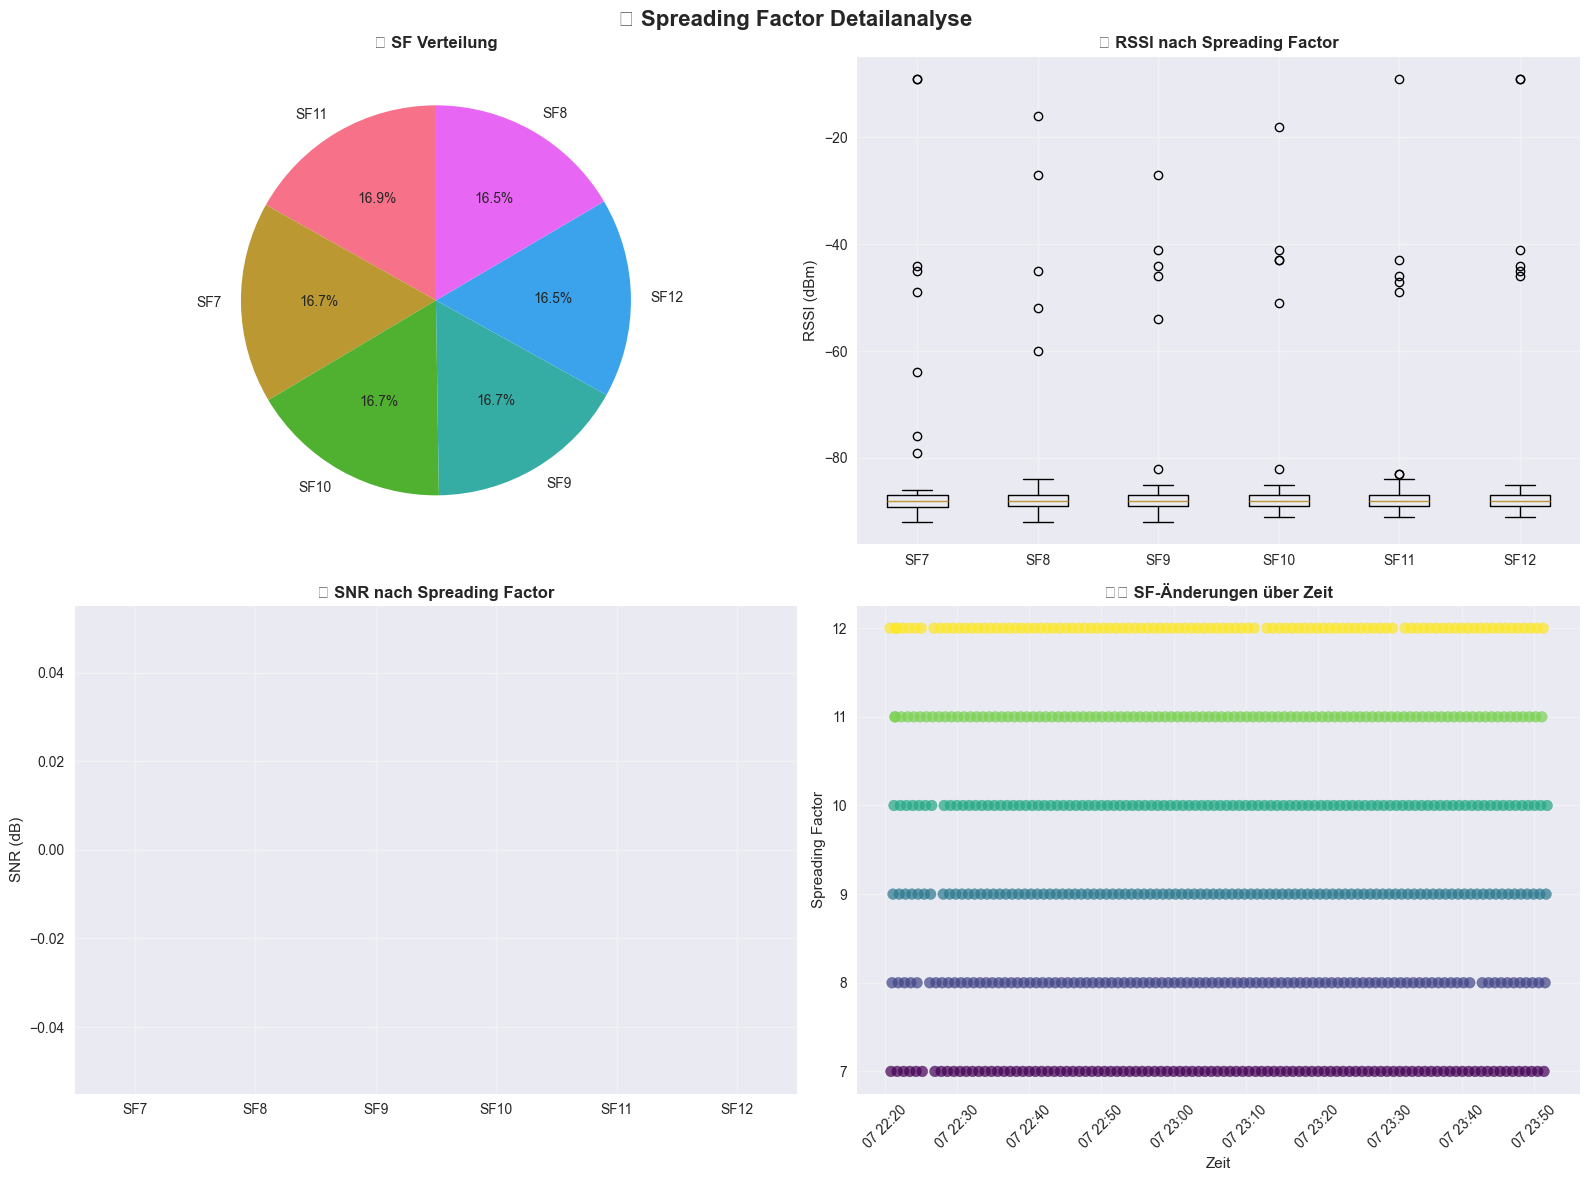


🔍 SF-KORRELATIONSANALYSE:
📈 SF vs RSSI Korrelation: 0.006
📈 SF vs SNR Korrelation: -0.179
📊 Schwache Korrelation: SF-Verhalten unabhängig von RSSI
📊 Schwache Korrelation: SF-Verhalten unabhängig von SNR


In [56]:
# 🎯 DETAILLIERTE SPREADING FACTOR ANALYSE
if len(df) > 0 and 'sf_numeric' in df.columns:
    print("🎯 DETAILLIERTE SPREADING FACTOR ANALYSE")
    print("=" * 60)
    
    # SF Grundstatistiken
    sf_stats = df['sf_numeric'].describe()
    print(f"🔄 SF Bereich: {sf_stats['min']:.0f} bis {sf_stats['max']:.0f}")
    print(f"📊 Durchschnittlicher SF: {sf_stats['mean']:.1f}")
    print(f"📈 Häufigster SF: {df['sf_numeric'].mode().iloc[0]:.0f}")
    
    # SF-Performance Analyse
    sf_performance = df.groupby('sf_numeric').agg({
        'rssi_dbm': ['mean', 'std', 'min', 'max'],
        'snr_db': ['mean', 'std', 'min', 'max'],
        'timestamp': 'count'
    }).round(2)
    
    print("\n📊 SF-Performance Übersicht:")
    for sf in sorted(df['sf_numeric'].unique()):
        if pd.notna(sf):
            sf_data = df[df['sf_numeric'] == sf]
            count = len(sf_data)
            avg_rssi = sf_data['rssi_dbm'].mean()
            avg_snr = sf_data['snr_db'].mean()
            percentage = (count / len(df)) * 100
            print(f"   SF{sf:.0f}: {count} Nachrichten ({percentage:.1f}%) | RSSI: {avg_rssi:.1f} dBm | SNR: {avg_snr:.1f} dB")
    
    # SF Visualisierungen
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🎯 Spreading Factor Detailanalyse', fontsize=16, fontweight='bold')
    
    # 1. SF Verteilung (Pie Chart)
    sf_counts = df['spreading_factor'].value_counts()
    axes[0, 0].pie(sf_counts.values, labels=sf_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('🔄 SF Verteilung', fontweight='bold')
    
    # 2. SF vs RSSI (Box Plot)
    sf_list = sorted(df['sf_numeric'].dropna().unique())
    rssi_by_sf = [df[df['sf_numeric'] == sf]['rssi_dbm'].values for sf in sf_list]
    axes[0, 1].boxplot(rssi_by_sf, labels=[f'SF{int(sf)}' for sf in sf_list])
    axes[0, 1].set_title('📶 RSSI nach Spreading Factor', fontweight='bold')
    axes[0, 1].set_ylabel('RSSI (dBm)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. SF vs SNR (Box Plot)
    snr_by_sf = [df[df['sf_numeric'] == sf]['snr_db'].values for sf in sf_list]
    axes[1, 0].boxplot(snr_by_sf, labels=[f'SF{int(sf)}' for sf in sf_list])
    axes[1, 0].set_title('📡 SNR nach Spreading Factor', fontweight='bold')
    axes[1, 0].set_ylabel('SNR (dB)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. SF über Zeit
    axes[1, 1].scatter(df['timestamp'], df['sf_numeric'], alpha=0.7, s=60, c=df['sf_numeric'], cmap='viridis')
    axes[1, 1].set_title('⏱️ SF-Änderungen über Zeit', fontweight='bold')
    axes[1, 1].set_xlabel('Zeit')
    axes[1, 1].set_ylabel('Spreading Factor')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # SF-Korrelationsanalyse
    print("\n🔍 SF-KORRELATIONSANALYSE:")
    print("=" * 40)
    
    # Korrelation zwischen SF und Signalqualität
    sf_rssi_corr = df['sf_numeric'].corr(df['rssi_dbm'])
    sf_snr_corr = df['sf_numeric'].corr(df['snr_db'])
    
    print(f"📈 SF vs RSSI Korrelation: {sf_rssi_corr:.3f}")
    print(f"📈 SF vs SNR Korrelation: {sf_snr_corr:.3f}")
    
    # Interpretation
    if sf_rssi_corr < -0.3:
        print("✅ Negative Korrelation: Höhere SF bei schlechterem RSSI (erwartetes Verhalten)")
    elif sf_rssi_corr > 0.3:
        print("⚠️ Positive Korrelation: Höhere SF bei besserem RSSI (unerwartet)")
    else:
        print("📊 Schwache Korrelation: SF-Verhalten unabhängig von RSSI")
    
    if sf_snr_corr < -0.3:
        print("✅ Negative Korrelation: Höhere SF bei schlechterem SNR (erwartetes Verhalten)")
    elif sf_snr_corr > 0.3:
        print("⚠️ Positive Korrelation: Höhere SF bei besserem SNR (unerwartet)")
    else:
        print("📊 Schwache Korrelation: SF-Verhalten unabhängig von SNR")
    
else:
    print("⚠️ Keine SF-Daten für Analyse verfügbar")

In [57]:
# Netzwerk-Parameter Statistiken
if len(df) > 0:
    print("📊 NETZWERK-PARAMETER STATISTIKEN")
    print("=" * 60)
    
    # RSSI Statistiken
    print("📶 RSSI (Received Signal Strength Indicator):")
    rssi_stats = df['rssi_dbm'].describe()
    print(f"   Durchschnitt: {rssi_stats['mean']:.2f} dBm")
    print(f"   Bereich: {rssi_stats['min']:.1f} bis {rssi_stats['max']:.1f} dBm")
    print(f"   Standardabweichung: {rssi_stats['std']:.2f} dBm")
    
    # SNR Statistiken
    print("\n📡 SNR (Signal-to-Noise Ratio):")
    snr_stats = df['snr_db'].describe()
    print(f"   Durchschnitt: {snr_stats['mean']:.2f} dB")
    print(f"   Bereich: {snr_stats['min']:.1f} bis {snr_stats['max']:.1f} dB")
    print(f"   Standardabweichung: {snr_stats['std']:.2f} dB")
    # Analyse der SNR-Robustheit
    low_snr_count = (df['snr_db'] < 0).sum()
    if low_snr_count > 0:
        print(f"   ✅ Robuste Verbindungen: {low_snr_count} Nachrichten mit SNR < 0 dB erfolgreich empfangen")
        print(f"   💪 Systemrobustheit: {(low_snr_count / len(df)) * 100:.1f}% funktionieren auch bei niedrigem SNR")
    
    # Spreading Factor Verteilung
    print("\n🔄 Spreading Factor Verteilung:")
    sf_counts = df['spreading_factor'].value_counts().sort_index()
    for sf, count in sf_counts.items():
        percentage = (count / len(df)) * 100
        print(f"   {sf}: {count} Nachrichten ({percentage:.1f}%)")
    
    # Frequenz Verteilung
    print("\n📻 Frequenz Verteilung:")
    freq_counts = df['frequency'].value_counts().sort_index()
    for freq, count in freq_counts.items():
        percentage = (count / len(df)) * 100
        freq_mhz = freq / 1_000_000  # Hz zu MHz
        print(f"   {freq_mhz:.1f} MHz: {count} Nachrichten ({percentage:.1f}%)")
    
    # Frame Counter Analyse
    if 'fcnt' in df.columns:
        print("\n🔢 Frame Counter:")
        fcnt_stats = df['fcnt'].describe()
        print(f"   Bereich: {fcnt_stats['min']:.0f} bis {fcnt_stats['max']:.0f}")
        if len(df) > 1:
            packet_loss = (fcnt_stats['max'] - fcnt_stats['min'] + 1) - len(df)
            if packet_loss > 0:
                loss_rate = (packet_loss / (fcnt_stats['max'] - fcnt_stats['min'] + 1)) * 100
                print(f"   Möglicher Paketverlust: {packet_loss} Pakete ({loss_rate:.1f}%)")
            else:
                print(f"   ✅ Kein Paketverlust erkannt")

📊 NETZWERK-PARAMETER STATISTIKEN
📶 RSSI (Received Signal Strength Indicator):
   Durchschnitt: -85.62 dBm
   Bereich: -92.0 bis -9.0 dBm
   Standardabweichung: 11.75 dBm

📡 SNR (Signal-to-Noise Ratio):
   Durchschnitt: -0.40 dB
   Bereich: -14.2 bis 15.0 dB
   Standardabweichung: 3.85 dB
   ✅ Robuste Verbindungen: 392 Nachrichten mit SNR < 0 dB erfolgreich empfangen
   💪 Systemrobustheit: 62.9% funktionieren auch bei niedrigem SNR

🔄 Spreading Factor Verteilung:
   SF10: 104 Nachrichten (16.7%)
   SF11: 105 Nachrichten (16.9%)
   SF12: 103 Nachrichten (16.5%)
   SF7: 104 Nachrichten (16.7%)
   SF8: 103 Nachrichten (16.5%)
   SF9: 104 Nachrichten (16.7%)

📻 Frequenz Verteilung:
   867.1 MHz: 1 Nachrichten (0.2%)
   867.5 MHz: 1 Nachrichten (0.2%)
   868.1 MHz: 183 Nachrichten (29.4%)
   868.3 MHz: 204 Nachrichten (32.7%)
   868.5 MHz: 234 Nachrichten (37.6%)

🔢 Frame Counter:
   Bereich: 17 bis 645
   Möglicher Paketverlust: 6.0 Pakete (1.0%)


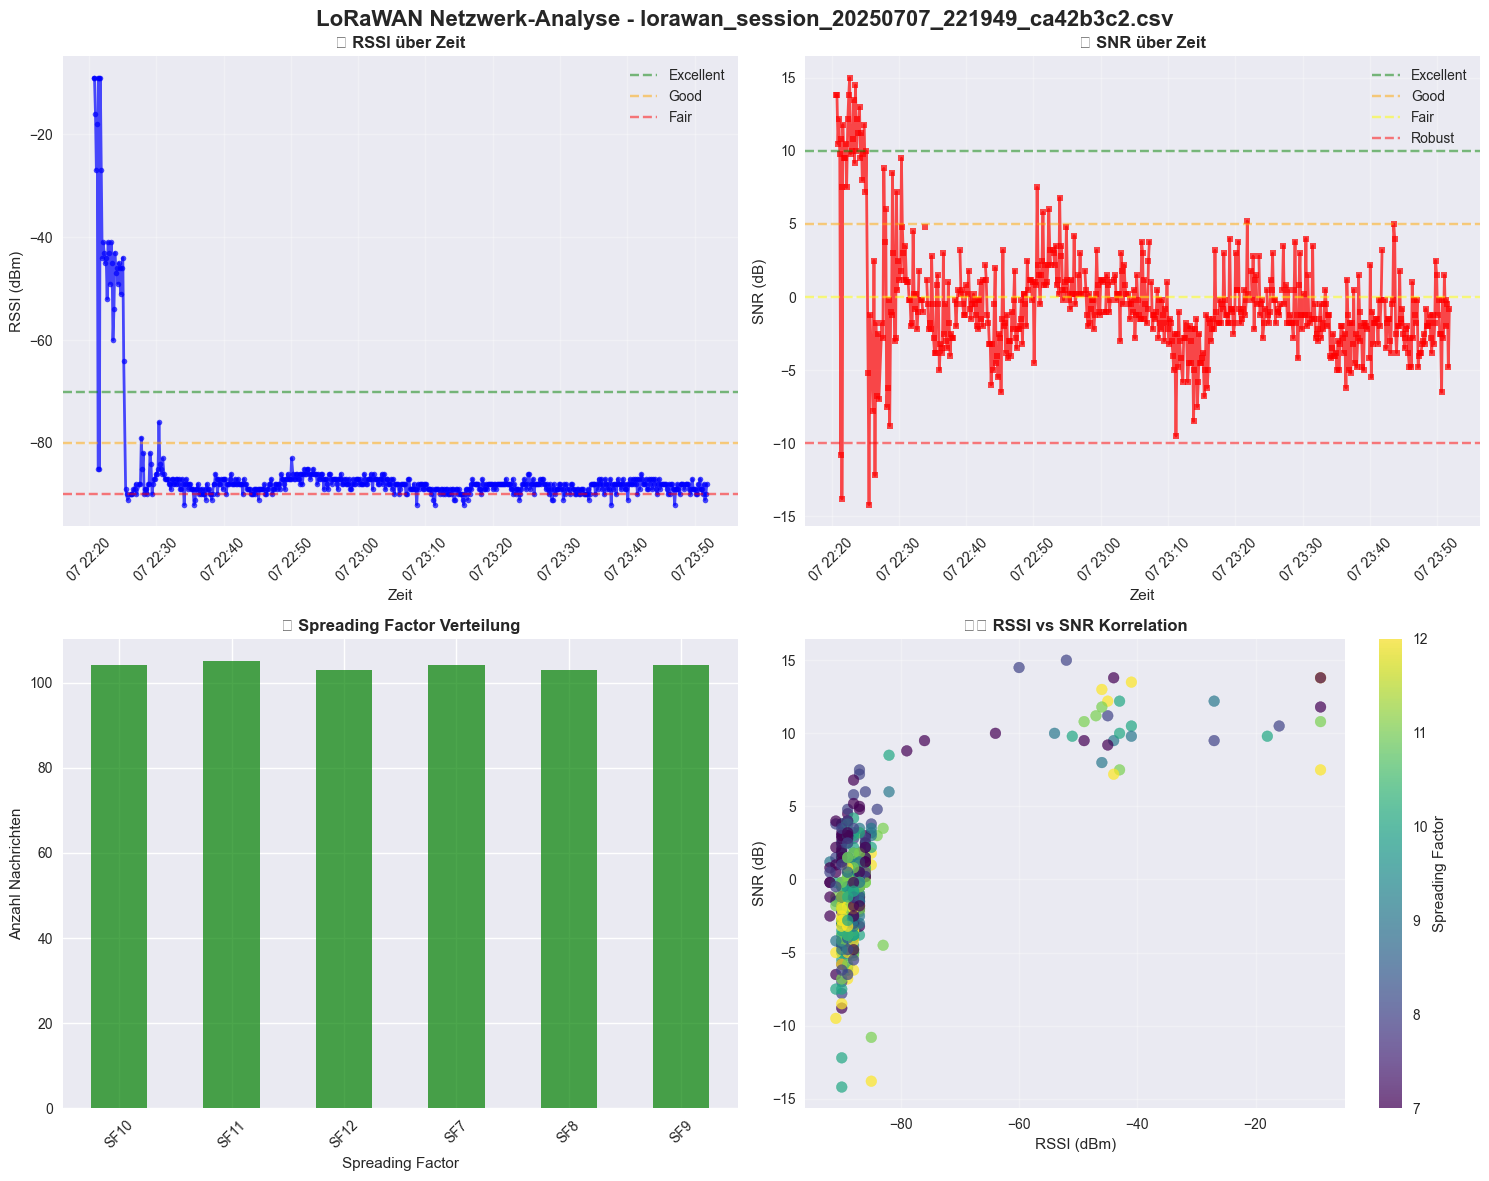

In [58]:
# LoRaWAN-Netzwerk Visualisierungen
if len(df) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'LoRaWAN Netzwerk-Analyse - {selected_file}', fontsize=16, fontweight='bold')
    
    # 1. RSSI über Zeit
    axes[0, 0].plot(df['timestamp'], df['rssi_dbm'], 'b-', alpha=0.7, linewidth=2, marker='o', markersize=4)
    axes[0, 0].set_title('📶 RSSI über Zeit', fontweight='bold')
    axes[0, 0].set_xlabel('Zeit')
    axes[0, 0].set_ylabel('RSSI (dBm)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Qualitätszonen einzeichnen
    axes[0, 0].axhline(-70, color='green', linestyle='--', alpha=0.5, label='Excellent')
    axes[0, 0].axhline(-80, color='orange', linestyle='--', alpha=0.5, label='Good')
    axes[0, 0].axhline(-90, color='red', linestyle='--', alpha=0.5, label='Fair')
    axes[0, 0].legend()
    
    # 2. SNR über Zeit
    axes[0, 1].plot(df['timestamp'], df['snr_db'], 'r-', alpha=0.7, linewidth=2, marker='s', markersize=4)
    axes[0, 1].set_title('📡 SNR über Zeit', fontweight='bold')
    axes[0, 1].set_xlabel('Zeit')
    axes[0, 1].set_ylabel('SNR (dB)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # SNR Qualitätszonen
    axes[0, 1].axhline(10, color='green', linestyle='--', alpha=0.5, label='Excellent')
    axes[0, 1].axhline(5, color='orange', linestyle='--', alpha=0.5, label='Good')
    axes[0, 1].axhline(0, color='yellow', linestyle='--', alpha=0.5, label='Fair')
    axes[0, 1].axhline(-10, color='red', linestyle='--', alpha=0.5, label='Robust')
    axes[0, 1].legend()
    
    # 3. Spreading Factor Verteilung
    sf_counts = df['spreading_factor'].value_counts().sort_index()
    sf_counts.plot(kind='bar', ax=axes[1, 0], color='green', alpha=0.7)
    axes[1, 0].set_title('🔄 Spreading Factor Verteilung', fontweight='bold')
    axes[1, 0].set_xlabel('Spreading Factor')
    axes[1, 0].set_ylabel('Anzahl Nachrichten')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. RSSI vs SNR Scatter mit Spreading Factor Farben
    if 'sf_numeric' in df.columns:
        scatter = axes[1, 1].scatter(df['rssi_dbm'], df['snr_db'], c=df['sf_numeric'], 
                                   cmap='viridis', alpha=0.7, s=60)
        plt.colorbar(scatter, ax=axes[1, 1], label='Spreading Factor')
    else:
        axes[1, 1].scatter(df['rssi_dbm'], df['snr_db'], alpha=0.7, s=60)
    
    axes[1, 1].set_title('📶📡 RSSI vs SNR Korrelation', fontweight='bold')
    axes[1, 1].set_xlabel('RSSI (dBm)')
    axes[1, 1].set_ylabel('SNR (dB)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Zu wenig Daten für Zeitreihen-Visualisierungen")

In [59]:
# Netzwerk-Performance Zusammenfassung
if len(df) > 0:
    print("\n" + "=" * 80)
    print("🎯 LoRaWAN NETZWERK-PERFORMANCE ZUSAMMENFASSUNG")
    print("=" * 80)
    
    # Berechne wichtige Metriken
    rssi_quality, snr_quality = analyze_signal_quality(df['rssi_dbm'], df['snr_db'])
    excellent_rssi_pct = (rssi_quality == 'Excellent').sum() / len(df) * 100
    excellent_snr_pct = (snr_quality == 'Excellent').sum() / len(df) * 100
    
    summary = {
        'Dateiname': selected_file,
        'Analysezeitpunkt': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Gesamtnachrichten': len(df),
        'Session_Zeitraum': f"{df['timestamp'].min()} bis {df['timestamp'].max()}",
        'Session_Dauer': str(df['timestamp'].max() - df['timestamp'].min()).split('.')[0],
        'Durchschnittliche_RSSI': f"{df['rssi_dbm'].mean():.2f} dBm",
        'RSSI_Bereich': f"{df['rssi_dbm'].min():.1f} bis {df['rssi_dbm'].max():.1f} dBm",
        'Durchschnittliche_SNR': f"{df['snr_db'].mean():.2f} dB",
        'SNR_Bereich': f"{df['snr_db'].min():.1f} bis {df['snr_db'].max():.1f} dB",
        'Häufigster_SF': df['spreading_factor'].mode().iloc[0] if not df['spreading_factor'].mode().empty else 'N/A',
        'Anzahl_Frequenzen': df['frequency'].nunique(),
        'Qualität_Excellent_RSSI': f"{excellent_rssi_pct:.1f}%",
        'Qualität_Excellent_SNR': f"{excellent_snr_pct:.1f}%",
        'Unique_Devices': df['device_eui'].nunique(),
        'Unique_Gateways': df['gateway_id'].nunique()
    }
    
    # Durchschnittliches Nachrichtenintervall
    if len(df) > 1:
        df_sorted = df.sort_values('timestamp')
        time_diffs = df_sorted['timestamp'].diff().dt.total_seconds().dropna()
        summary['Durchschnittliches_Intervall'] = f"{time_diffs.mean():.2f} Sekunden"
    
    # Ausgabe der Zusammenfassung
    for key, value in summary.items():
        print(f"{key.replace('_', ' ')}: {value}")
    
    print("\n" + "=" * 80)
    print("📤 EXPORT-OPTIONEN")
    print("=" * 80)
    print("Sie können die Analyseergebnisse exportieren:")
    print("1. Netzwerkdaten als CSV: df.to_csv('lorawan_network_analysis.csv', index=False)")
    print("2. Zusammenfassung als JSON: import json; json.dump(summary, open('network_summary.json', 'w'), indent=2)")
    print("3. Grafiken als PNG: plt.savefig('lorawan_plots.png', dpi=300, bbox_inches='tight')")
    
    print("\n🎉 LoRaWAN Netzwerk-Analyse abgeschlossen!")
else:
    print("❌ Keine Daten verfügbar für Analyse")


🎯 LoRaWAN NETZWERK-PERFORMANCE ZUSAMMENFASSUNG
Dateiname: lorawan_session_20250707_221949_ca42b3c2.csv
Analysezeitpunkt: 2025-07-09 13:38:48
Gesamtnachrichten: 623
Session Zeitraum: 2025-07-07 22:20:40 bis 2025-07-07 23:51:49
Session Dauer: 0 days 01:31:09
Durchschnittliche RSSI: -85.62 dBm
RSSI Bereich: -92.0 bis -9.0 dBm
Durchschnittliche SNR: -0.40 dB
SNR Bereich: -14.2 bis 15.0 dB
Häufigster SF: SF11
Anzahl Frequenzen: 5
Qualität Excellent RSSI: 5.1%
Qualität Excellent SNR: 3.4%
Unique Devices: 1
Unique Gateways: 1
Durchschnittliches Intervall: 8.79 Sekunden

📤 EXPORT-OPTIONEN
Sie können die Analyseergebnisse exportieren:
1. Netzwerkdaten als CSV: df.to_csv('lorawan_network_analysis.csv', index=False)
2. Zusammenfassung als JSON: import json; json.dump(summary, open('network_summary.json', 'w'), indent=2)
3. Grafiken als PNG: plt.savefig('lorawan_plots.png', dpi=300, bbox_inches='tight')

🎉 LoRaWAN Netzwerk-Analyse abgeschlossen!



📊 VISUELLE DARSTELLUNG: SPREADING FACTOR UND SNR


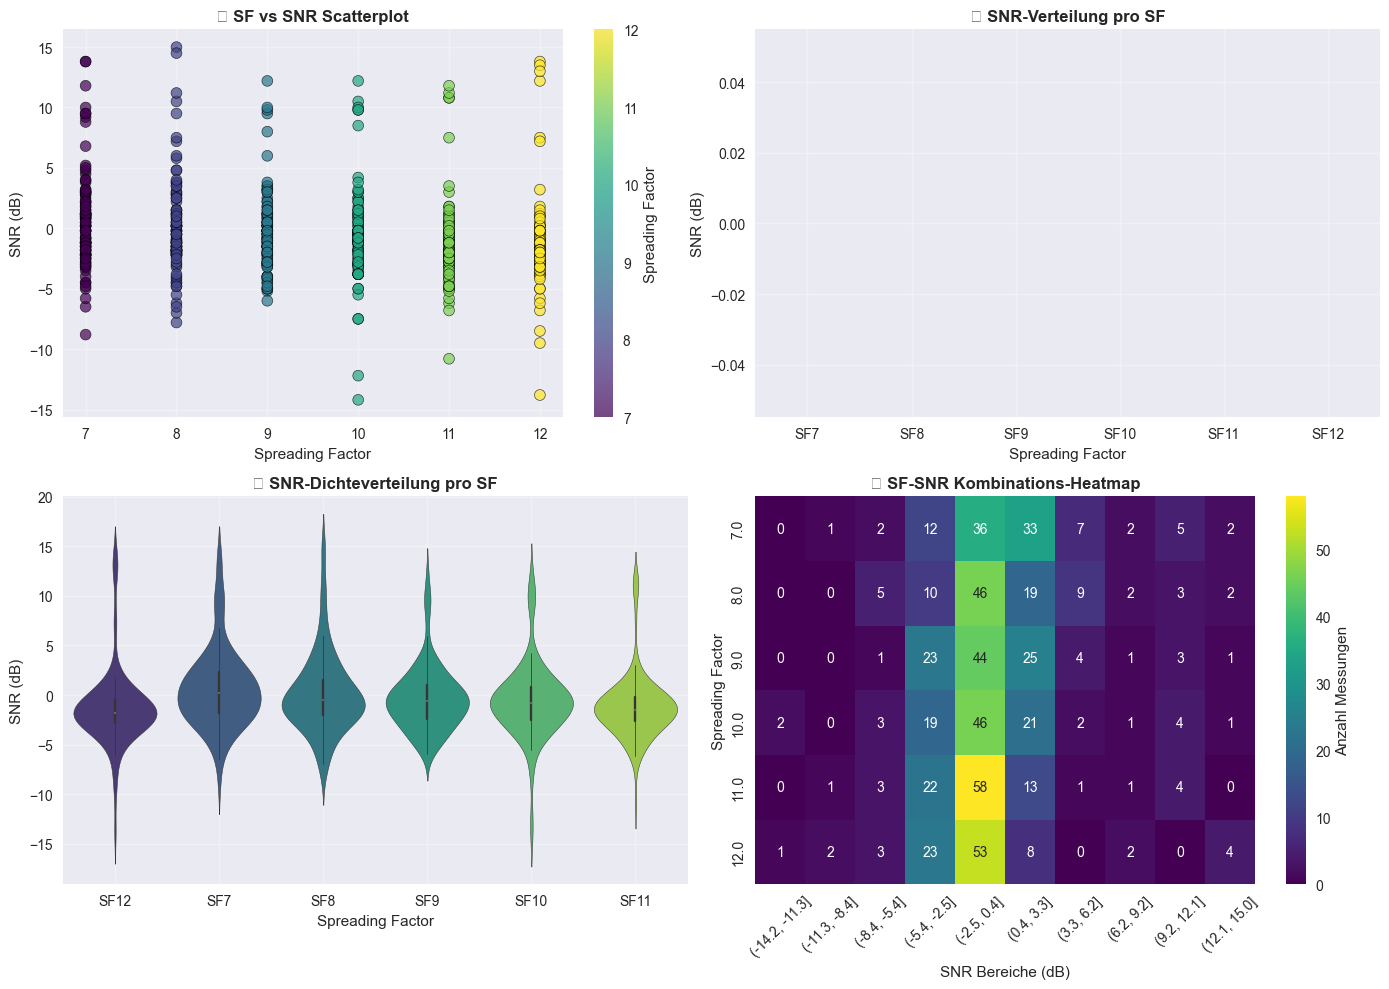


📈 STATISTISCHE AUSWERTUNG PRO SF:
            count  mean   std   min   max  median
sf_numeric                                       
7.0           100  0.71  4.06  -8.8  13.8    0.20
8.0            96  0.20  4.10  -7.8  15.0   -0.50
9.0           102 -0.31  3.32  -6.0  12.2   -0.65
10.0           99 -0.55  3.91 -14.2  12.2   -0.80
11.0          103 -1.14  3.38 -10.8  11.8   -1.50
12.0           96 -1.27  4.02 -13.8  13.8   -1.80

✅ Bester SF (höchste durchschnittliche SNR): SF7 mit 0.71 dB
❌ Schlechtester SF (niedrigste durchschnittliche SNR): SF12 mit -1.27 dB

💡 EMPFEHLUNGEN:
SF7: 🟠 Fair - 0.71 dB (n=100)
SF8: 🟠 Fair - 0.20 dB (n=96)
SF9: 💪 Robust (niedriges SNR aber funktional) - -0.31 dB (n=102)
SF10: 💪 Robust (niedriges SNR aber funktional) - -0.55 dB (n=99)
SF11: 💪 Robust (niedriges SNR aber funktional) - -1.14 dB (n=103)
SF12: 💪 Robust (niedriges SNR aber funktional) - -1.27 dB (n=96)

🎯 Analyse der SF-SNR Beziehungen abgeschlossen!


In [60]:
# Visuelle Darstellung der einzelnen SF und die dazugehörigen SNR Daten
if len(df) > 0:
    print("\n" + "=" * 80)
    print("📊 VISUELLE DARSTELLUNG: SPREADING FACTOR UND SNR")
    print("=" * 80)
    
    # 1. Scatterplot: SF vs SNR
    plt.figure(figsize=(14, 10))
    
    # Subplot 1: SF vs SNR Scatterplot
    plt.subplot(2, 2, 1)
    if 'sf_numeric' in df.columns and 'snr_db' in df.columns:
        scatter = plt.scatter(df['sf_numeric'], df['snr_db'], 
                            c=df['sf_numeric'], cmap='viridis', 
                            alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
        plt.colorbar(scatter, label='Spreading Factor')
        plt.xlabel('Spreading Factor')
        plt.ylabel('SNR (dB)')
        plt.title('📡 SF vs SNR Scatterplot', fontweight='bold')
        plt.grid(True, alpha=0.3)
    
    # Subplot 2: Box Plot für SNR pro SF
    plt.subplot(2, 2, 2)
    if 'sf_numeric' in df.columns and 'snr_db' in df.columns:
        sf_values = sorted(df['sf_numeric'].dropna().unique())
        snr_data = [df[df['sf_numeric'] == sf]['snr_db'].values for sf in sf_values]
        
        bp = plt.boxplot(snr_data, labels=[f'SF{int(sf)}' for sf in sf_values], 
                        patch_artist=True, showmeans=True)
        
        # Farbcodierung für Boxplots
        colors = plt.cm.viridis(np.linspace(0, 1, len(bp['boxes'])))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        plt.xlabel('Spreading Factor')
        plt.ylabel('SNR (dB)')
        plt.title('📊 SNR-Verteilung pro SF', fontweight='bold')
        plt.grid(True, alpha=0.3)
    
    # Subplot 3: Violin Plot für detaillierte Verteilung
    plt.subplot(2, 2, 3)
    if 'sf_numeric' in df.columns and 'snr_db' in df.columns:
        # Erstelle DataFrame für Seaborn
        df_plot = df[['sf_numeric', 'snr_db']].dropna()
        df_plot['sf_label'] = df_plot['sf_numeric'].apply(lambda x: f'SF{int(x)}')
        
        sns.violinplot(data=df_plot, x='sf_label', y='snr_db', palette='viridis')
        plt.xlabel('Spreading Factor')
        plt.ylabel('SNR (dB)')
        plt.title('🎻 SNR-Dichteverteilung pro SF', fontweight='bold')
        plt.grid(True, alpha=0.3)
    
    # Subplot 4: Heatmap für SF-SNR Kombinationen
    plt.subplot(2, 2, 4)
    if 'sf_numeric' in df.columns and 'snr_db' in df.columns:
        # Erstelle Bins für SNR
        df_temp = df[['sf_numeric', 'snr_db']].dropna()
        df_temp['snr_bin'] = pd.cut(df_temp['snr_db'], bins=10, precision=1)
        
        # Erstelle Pivot-Tabelle für Heatmap
        heatmap_data = df_temp.groupby(['sf_numeric', 'snr_bin']).size().unstack(fill_value=0)
        
        if not heatmap_data.empty:
            sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis', 
                       cbar_kws={'label': 'Anzahl Messungen'})
            plt.xlabel('SNR Bereiche (dB)')
            plt.ylabel('Spreading Factor')
            plt.title('🔥 SF-SNR Kombinations-Heatmap', fontweight='bold')
            plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Zusätzliche statistische Analyse
    print("\n📈 STATISTISCHE AUSWERTUNG PRO SF:")
    print("=" * 50)
    
    if 'sf_numeric' in df.columns and 'snr_db' in df.columns:
        sf_snr_stats = df.groupby('sf_numeric')['snr_db'].agg([
            'count', 'mean', 'std', 'min', 'max', 'median'
        ]).round(2)
        
        print(sf_snr_stats)
        
        # Beste und schlechteste SF Performance
        best_sf = sf_snr_stats['mean'].idxmax()
        worst_sf = sf_snr_stats['mean'].idxmin()
        
        print(f"\n✅ Bester SF (höchste durchschnittliche SNR): SF{int(best_sf)} mit {sf_snr_stats.loc[best_sf, 'mean']:.2f} dB")
        print(f"❌ Schlechtester SF (niedrigste durchschnittliche SNR): SF{int(worst_sf)} mit {sf_snr_stats.loc[worst_sf, 'mean']:.2f} dB")
        
        # Empfehlungen
        print("\n💡 EMPFEHLUNGEN:")
        print("=" * 30)
        
        for sf in sorted(df['sf_numeric'].unique()):
            if pd.notna(sf):
                sf_int = int(sf)
                mean_snr = sf_snr_stats.loc[sf, 'mean']
                count = sf_snr_stats.loc[sf, 'count']
                
                if mean_snr >= 10:
                    status = "✅ Excellent"
                elif mean_snr >= 5:
                    status = "🟡 Good"
                elif mean_snr >= 0:
                    status = "🟠 Fair"
                elif mean_snr >= -10:
                    status = "💪 Robust (niedriges SNR aber funktional)"
                else:
                    status = "❌ Poor"
                
                print(f"SF{sf_int}: {status} - {mean_snr:.2f} dB (n={count})")
    
    print("\n🎯 Analyse der SF-SNR Beziehungen abgeschlossen!")
else:
    print("⚠️ Keine Daten für SF-SNR Visualisierung verfügbar")